In [1]:
import matplotlib.pyplot as plt
import numpy
import scipy

from metricdiversity.model.gaussian_process import GaussianProcessSimple as GP

In [7]:
NUM_MC_SAMPLES = 512

class MultiOutputGP:
    def __init__(self, X, Y):
        """
        X: n by d numpy array
        Y: n by m numpy array
        Y here is vector valued, not scalar valued
        """
        self.gaussian_processes = []
        self.n = X.shape[0]
        self.d = X.shape[1]
        self.m = Y.shape[1]
        for i in range(self.m):
            gaussian_process = GP(X, Y[:, i])
            gaussian_process.train()
            self.gaussian_processes.append(gaussian_process)
    
    def sample(self, n_samples, x):
        """
        Inputs
        x: 1 by d numpy array
        Y: n_samples by m array
        """
        Y = []
        for i in range(self.m):
            Y.append(self.gaussian_processes[i].sample(n_samples, x).flatten())
        return numpy.array(Y).T
            
    def get_historical_data(self):
        Y = []
        X = None
        for gp in self.gaussian_processes:
            X, y = gp.get_historical_data()
            Y.append(y)
        return (
            X,
            numpy.array(Y).T
        )
    
    def predict(self, X):
        Y = []
        for i in range(self.m):
            Y.append(self.gaussian_processes[i].predict(X).flatten())
        return numpy.array(Y).T

    
class ThresholdBox:
    def __init__(self, ub, lb):
        """
        Input
        ub, lb: array or list (shouldn't matter) of length m
        """
        self.ub = ub
        self.lb = lb
    
    def points_in_box(self, Y):
        """
        Input
        Y: n x m set of points 
        Output
        Y_in: subset of points in Y that are within threshold values
        """
        idx_under_ub = numpy.all(Y <= self.ub, axis=1)
        Y = Y[idx_under_ub]
        idx_over_lb = numpy.all(Y >= self.lb, axis=1)
        Y = Y[idx_over_lb]
        return Y
    
    
class ExpectedMetricCoverage:
    
    def __init__(self, gaussian_process, ub, lb, punchout_radius):
        self.gaussian_process = gaussian_process
        self.threshold_box = ThresholdBox(ub, lb)
        self.punchout_radius = punchout_radius
    
    def compute_expected_utility(self, x):
        """
        Compute value via MC by generating sampling from y distribution at a point x, and then 
        tossing points that are either outside the threshold box or too close to an existing metric value
        """
        x = numpy.atleast_2d(x)
        Y_samples = self.gaussian_process.sample(NUM_MC_SAMPLES, x)
        Y_in_box = self.threshold_box.points_in_box(Y_samples)
        _, Y_obs = self.gaussian_process.get_historical_data()
        dist_matrix = scipy.spatial.distance.cdist(Y_in_box, Y_obs)
        idx_outside_range = numpy.all(dist_matrix > self.punchout_radius, axis=1)
        return sum(idx_outside_range) / NUM_MC_SAMPLES

# Two Dimensions, Two Objectives

We first start with a small toy example, in which we learn a multioutput GP using a few training points

In [8]:
# define objective 
def yf2d(x):
    v1 = numpy.exp(-2 * (x[:, 0] - 0.3) ** 2 - 4 * (x[:, 1] - 0.6) ** 2)
    v2 = numpy.exp(-3 * (x[:, 0] - 0.1) ** 2 - 3 * (x[:, 1] - 0.1) ** 2)
    return numpy.stack((v1, v2)).T


# Select a few observations at random
numpy.random.seed(1234)
Xtrain = numpy.random.rand(6, 2)
Ytrain = yf2d(Xtrain)
gpm = MultiOutputGP(Xtrain, Ytrain)

Next, we use the GP to predict a set of unseen values spread out on a grid. We keep the colors of parameters and their corresponding metrics consistent to make things clear

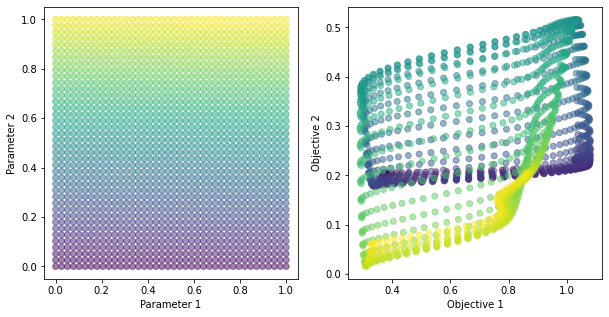

In [9]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))

d = 2
N1, N2 = 40, 40
Xplt, Yplt = numpy.meshgrid(numpy.linspace(0, 1, N1), numpy.linspace(0, 1, N2))
X = numpy.stack((Xplt.flatten(), Yplt.flatten())).T
Y = gpm.predict(X)


t = numpy.arange(N1*N2)
axes[0].set_xlabel('Parameter 1')
axes[0].set_ylabel('Parameter 2')
axes[0].scatter(X[:, 0], X[:, 1], c=t alpha=0.5)

axes[1].set_xlabel('Objective 1')
axes[1].set_ylabel('Objective 2')
axes[1].scatter(Y[:, 0], Y[:, 1], c=t, alpha=0.5)



Finally, we compute the expected metric coverage utility function, and instead shade the parameter and metric values based on the value of this utility function. 

For the threshold, we selec

We pick a fairly reasonable threshold and punchout radius, and we see that this utility function appears to function as intended.

In [10]:
ub = [0.9, 0.9]
lb = [0.1, 0.1]
punchout_radius = 0.2
ecim = ExpectedMetricCoverage(gpm, ub, lb, punchout_radius)
values = []
for i in range(N1*N2):
    x = X[i, :]
    values.append(ecim.compute_expected_utility(x))


[]

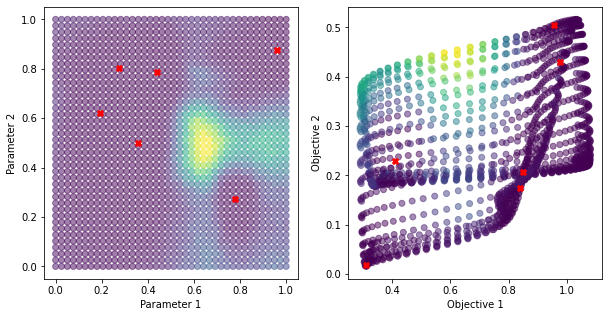

In [12]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))

axes[0].set_xlabel('Parameter 1')
axes[0].set_ylabel('Parameter 2')
axes[0].scatter(X[:, 0], X[:, 1], c=values, alpha=0.5)
axes[0].scatter(Xtrain[:, 0], Xtrain[:, 1], marker='X', color='r')

axes[1].set_xlabel('Objective 1')
axes[1].set_ylabel('Objective 2')
axes[1].scatter(Y[:, 0], Y[:, 1], c=values, alpha=0.5)
cmap = axes[1].scatter(Ytrain[:, 0], Ytrain[:, 1], marker='X', color='r')

axes[1].plot()

# fig.colorbar(cmap)

